# Tweets Disaster Classification: LSTM, Attention and Transformers <br>
Author: TeYang, Lau<br>
Created: 18/2/2020<br>
Last update: 6/1/2021<br>

<img src = 'https://bn1301files.storage.live.com/y4m-toxx6sX6SL9zvwtvAbEi9xPKLkgI6kdJ0PJ0uWjzQIR5GouWmvWfMBEuppVlUoFh3eZkKSrveb0QWnLNHPfHVwlBx55CtJMcmqurAYyBv-a2d1rSAmBUxU9CYHY7zZ50XIldgPJMkU7o18TcvrbPJatlu7ioKXMNV0qyev-Z1ise-zNPFjcYmbqz52FSyeW?width=5048&height=1838&cropmode=none' width="900">

<br><br>

In the era of big data, text and sequential data are the most uniquitous, from social media to medical records to speech recordings. As such, **natural language processing** problems are present in most fields and industry, and deep neural networks that can learn and tackle these problems are becoming increasingly important. The purpose of this notebook is to use some of the most common and effective models to tackle a **sentence classification** problem, specifically, to classify whether a tweet is about a disaster or not. This is easy for a human, but a computer will find it difficult as languages contain multiple complexities. A model will thus will have to take into account the sequential nature of the tweet, the meaning and representation of each word in numbers, as well as the importance and contribution of other words in the same sequence, since two words can have completely different meanings in two different contexts. For example, take the word `kill`. Although it might seem to indicate a disaster, what if it was used in a different context, such as when referring to the book 'To kill a mockingbird'? Thus, NLP is not an easy problem for a computer to solve but recent advances has greatly advanced this process.  

The dataset contains 10,000 tweets that were classified as disaster or non-disaster.


## Project Goals
1. *Explore* using different sequence models **(LSTM, Attention, Transformers)** for NLP sentence classification problem
2. *Preprocess/Clean* tweets data into appropriate format for inputting into neural network models 
3. *Understand* **word embeddings** and how they are used to represent words as inputs into NLP models
4. *Engineer* new features from tweets data that can help to improve model classification


### What's in this notebook:
1. [Data Loading and Structure](#Data_loading_structure)
2. [Exploratory Data Analysis of Tweets](#EDA) <br>
2.1. [Distribution of Character, Word and Sentence Frequency](#Frequency_Distribution) <br>
2.2. [Top Most Common Stopwords](#Top_Stopwords) <br>
2.3. [Top Most Common Punctuations](#Top_Punc) <br>
2.4. [Top Most Common Words](#Top_Words) <br>
2.5. [Wordcloud for Hashtags](#Hashtags) <br>
3. [Meta-Feature Engineering](#Feature_Engineer)
4. [Text Data Cleaning](#Data_Clean) <br>
4.1. [Ngrams](#Ngrams) <br>
4.2. [WordCloud of Most Common Words after Cleaning](#WC_Cleaned)
5. [Train Validation Data Split](#TrainValSplit)    
6. [Embedding Layer](#Embedding) <br>
6.1. [Tokenization](#Tokenization) <br>
6.2. [Padding](#Padding) <br>
6.3. [Embedding Matrix – GloVe](#E_Matrix) <br>
7. [Model Building & Training](#Model_Build) <br>
7.1. [Long Short-Term Memory (LSTM)](#LSTM) <br>
7.2. [Bidirectional LSTM with Attention](#Attention) <br>
7.3. [BERT](#BERT)
8. [Error Analysis](#Error)
9. [Testing](#Test)
10. [Conclusion](#Conclusion)<br><br>

<a id='Data_loading_structure'></a>
# 1. Data Loading and Structure

In [13]:
import numpy as np 
import pandas as pd 

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from ipywidgets import FileUpload

def on_upload_change(change):
    if change.new==0:
        print ('cleared')
        return
    up = change.owner
    print (type(up.value))
    for filename,data in up.value.items():
        print('==========================================================================================')
        print(filename)
        for k,v in data['metadata'].items():
            print(f'    -{k:13}:[{v}]')
        print(f'    -content len  :[{len(data["content"])}]')
        print('==========================================================================================')
    up.value.clear()
    up._counter = 0

upload_btn = FileUpload()
upload_btn.observe(on_upload_change, names='_counter')
upload_btn

from google.colab import files
data_to_load = files.upload()
import io
tweets = pd.read_csv(io.BytesIO(data_to_load['train.csv']))
#tweets = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

#tweets = pd.read_csv(r'C:\Users\TeYan\OneDrive\Work\Kaggle\Tweets_Disaster\Data\train.csv')
#tweets = pd.read_csv('/Users/teyang/OneDrive/Work/Kaggle/Tweets_Disaster/Data/train.csv')

Saving train.csv to train (3).csv


In [14]:
tweets.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


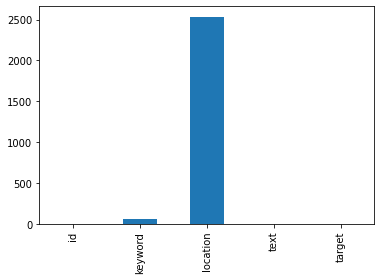

In [15]:
tweets.isnull().sum().plot(kind='bar')

Location has lots of NaN values and would not be a good/useful feature, unless we have a priori knowledge of where a disaster occured. Furthermore, some of them are not in the correct format, so it will be quite time consuming to clean it. 

Keyword has NaNs as well, but can be imputed with 'None'.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Samples')

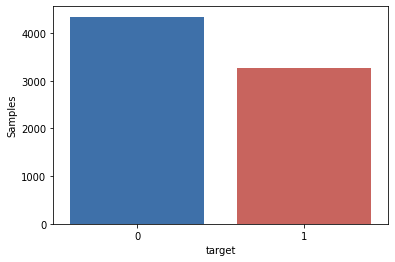

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

color = [sns.xkcd_rgb['medium blue'], sns.xkcd_rgb['pale red']]
sns.countplot('target',data = tweets, palette = color)
plt.gca().set_ylabel('Samples')

<a id='EDA'></a>
# 2. Exploratory Data Analysis of Tweets

<a id='Frequency_Distribution'></a>
## 2.1. Distribution of Character, Word and Sentence Frequency

In [18]:
#import nltk
#nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

# count number of characters in each tweet
tweets['char_len'] = tweets.text.str.len()

# count number of words in each tweet
word_tokens = [len(word_tokenize(tweet)) for tweet in tweets.text]
tweets['word_len'] = word_tokens

# count number of sentence in each tweet
sent_tokens = [len(sent_tokenize(tweet)) for tweet in tweets.text]
tweets['sent_len'] = sent_tokens

plot_cols = ['char_len','word_len','sent_len']
plot_titles = ['Character Length','Word Length','Sentence Length']

plt.figure(figsize=(20,4))
for counter, i in enumerate([0,1,2]):
    plt.subplot(1,3,counter+1)
    sns.distplot(tweets[tweets.target == 1][plot_cols[i]], label='Disaster', color=color[1]).set_title(plot_titles[i])
    sns.distplot(tweets[tweets.target == 0][plot_cols[i]], label='Non-Disaster', color=color[0])
    plt.legend()




TypeError: ignored

In [ ]:
# Investigate the Outliers

tweets[tweets.sent_len > 8]
tweets[tweets.word_len > 50]

Some of the outliers such as sentence length > 10 consist of a lot of punctuations. I left it unchanged as I feel that a  tweet with a many sentences, which is indicative of many punctuations, suggest that it is not a serious tweet (about a disaster). Of course there might be some instances where a disaster tweet consists of multiple punctuations (e.g. a volvano just erupted!!!!!!!!!!!!) but that is not very frequent.


<a id='Top_Stopwords'></a>
## 2.2. Top Most Common Stopwords

In [ ]:
## Plot most common stopwords

#nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Get all the word tokens in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in tweets[tweets.target == 0].text for word in word_tokenize(tweet)]
corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in tweets[tweets.target == 1].text for word in word_tokenize(tweet)]

# Function for counting top stopwords in a corpus
def count_top_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop: 
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:10] # get the top 10 stopwords
    x,y = zip(*topwords) # get key and values
    return x,y

x0,y0 = count_top_stopwords(corpus0)
x1,y1 = count_top_stopwords(corpus1)

# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=color[0])
plt.title('Top Stopwords for Non-Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=color[1])
plt.title('Top Stopwords for  Disaster Tweets')






There are lots of occurences of stopwords. These should be removed as they do not predict the target.

<a id='Top_Punc'></a>
## 2.3. Top Most Common Punctuations

In [ ]:
## Plot most common punctuations

from string import punctuation

# Get all the punctuations in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(c) for tweet in tweets[tweets.target == 0].text for c in tweet]
corpus0 = list(filter(lambda x: x in punctuation, corpus0)) # use filter to select only punctuations
corpus1 = [] # Disaster
[corpus1.append(c) for tweet in tweets[tweets.target == 1].text for c in tweet]
corpus1 = list(filter(lambda x: x in punctuation, corpus1)) 

from collections import Counter
x0,y0 = zip(*Counter(corpus0).most_common())
x1,y1 = zip(*Counter(corpus1).most_common())

# Plot bar plot of top punctuations for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=color[0])
plt.title('Top Punctuations for Non-Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=color[1])
plt.title('Top Punctuations for Disaster Tweets')





Most common punctuation is the slash, which usually comes from a link ('http://t.co/'). URLs should be removed, as well as most punctuations, with the exception of '!?', which signal some kind of intensity or tonality of the tweet.


<a id='Top_Words'></a>
## 2.4. Top Most Common Words

In [ ]:
## Plot most common words
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop = ENGLISH_STOP_WORDS.union(stop) # combine stop words from different sources

# function for removing url from text
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Get all the word tokens in dataframe for Disaster and Non-Disaster
# - remove url, tokenize tweet into words, lowercase words
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in tweets[tweets.target == 0].text for word in word_tokenize(remove_url(tweet))]
corpus0 = list(filter(lambda x: x not in stop, corpus0)) # use filter to unselect stopwords

corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in tweets[tweets.target == 1].text for word in word_tokenize(remove_url(tweet))]
corpus1 = list(filter(lambda x: x not in stop, corpus1)) # use filter to unselect stopwords

# Create df for word counts to use sns plots
a = Counter(corpus0).most_common()
df0 = pd.DataFrame(a, columns=['Word','Count'])

a = Counter(corpus1).most_common()
df1 = pd.DataFrame(a, columns=['Word','Count'])

# Plot for Disaster and Non-Disaster
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='Word',y='Count',data=df0.head(10), color=color[1]).set_title('Most Common Words for Non-Disasters')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x='Word',y='Count',data=df1.head(10), color=color[0]).set_title('Most Common Words for Disasters')
plt.xticks(rotation=45)






Disaster tweets contain more words related to disasters. But still need more cleaning. And what is the word amp? Will need to expand contractions as well such as 'im'.

<a id='Hashtags'></a>
## 2.5. Wordcloud for Hashtags

In [ ]:
def clean(word):
    for p in punctuation: word = word.replace(p, '')
    return word

from wordcloud import WordCloud

def wc_hash(target):
    hashtag = [clean(w[1:].lower()) for tweet in tweets[tweets.target == target].text for w in tweet.split() if '#' in w and w[0] == '#']
    hashtag = ' '.join(hashtag)
    my_cloud = WordCloud(background_color='white', stopwords=stop).generate(hashtag)

    plt.subplot(1,2,target+1)
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")

plt.figure(figsize=(15,4))
wc_hash(0)
plt.title('Non-Disaster')
wc_hash(1)
plt.title('Disaster')


<a id='Feature_Engineer'></a>
# 3. Meta-Feature Engineering

Here, we extract some features from the tweets that might give us some idea about whether it is a disaster or not. The purpose of this is to build a feature-based model and use it as part of an ensemble model to improve the predictions of the sequence model. Although it might not perform well on its own, it can  actually boost the performance when combined with other models.

* polarity - range of \[-1,1] where 1 denotes positivity and -1 denotes negativity
* subjectivity - range of \[0,1] where 1 denotes personal opinions and 0 denotes factual info
* exclaimation_num - number of exclamation marks in tweet
* questionmark_num - number of question marks in tweet
* url_num - number of urls in tweet
* hash_num - number of hashtags (#) in tweet
* mention_num - number of mentions (@) in tweet
* contraction_num - number of contractions (e.g I'm, we're, we've)

In [ ]:
from textblob import TextBlob

# polarity and subjectivity
tweets['polarity'] = [TextBlob(tweet).sentiment.polarity for tweet in tweets.text]
tweets['subjectivity'] = [TextBlob(tweet).sentiment.subjectivity for tweet in tweets.text]

#############################################################################################################################
# exclaimation and question marks
tweets['exclaimation_num'] = [tweet.count('!') for tweet in tweets.text]
tweets['questionmark_num'] = [tweet.count('?') for tweet in tweets.text]

#############################################################################################################################
# count number of hashtags and mentions
# Function for counting number of hashtags and mentions
def count_url_hashtag_mention(text):
    urls_num = len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    word_tokens = text.split()
    hash_num = len([word for word in word_tokens if word[0] == '#' and word.count('#') == 1]) # only appears once in front of word 
    mention_num = len([word for word in word_tokens if word[0] == '@' and word.count('@') == 1]) # only appears once in front of word 
    return urls_num, hash_num, mention_num

url_num, hash_num, mention_num = zip(*[count_url_hashtag_mention(tweet) for tweet in tweets.text])
tweets = tweets.assign(url_num = url_num, hash_num = hash_num, mention_num = mention_num)

#############################################################################################################################
# count number of contractions
contractions = ["'t", "'re", "'s", "'d", "'ll", "'ve", "'m"]
tweets['contraction_num'] = [sum([tweet.count(cont) for cont in contractions]) for tweet in tweets.text]


In [ ]:
tweets.head()

<a id='Data_Clean'></a>
# 4. Text Data Cleaning

This is the most important step of the entire project — text preprocessing/cleaning. This cleans the text into a more 'suitable' form as inputs into the NLP models. For example, URLs might make the text difficult to understand and should be removed when necessary. The choice of whether to remove/clean some words or parts-of-speech is an entire process on its own and sometimes this needs to be experimented. Different models are also able to deal with different kinds of parts-of-speech.

* Replace NaNs with 'None'
* Expand Contractions
* Remove Emojis
* Remove URLs
* Remove Punctuations except '!?' as they convey intensity and tonality of tweet
* Replace 'amp' with 'and'
* Word Segmentaion - segment words such as 'iwould' into 'i' and 'would'
* Lemmatization - reduces inflected words into their root form; verb part-of-speech tag is used here)
* Ngrams Exploration 
* Remove Stopwords
* WordCloud of most commmon words (Unigrams)

In [ ]:
## Replace NaNs with 'None'
tweets.keyword.fillna('None', inplace=True) 

#############################################################################################################################
## Expand Contractions

# Function for expanding most common contractions https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

tweets.text = [decontraction(tweet) for tweet in tweets.text]

#############################################################################################################################
## Remove Emojis

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

print(remove_emoji("OMG there is a volcano eruption!!! 😭😱😷"))

tweets.text = tweets.text.apply(lambda x: remove_emoji(x))

In [ ]:
#############################################################################################################################
## Remove URLs
tweets.text = tweets.text.apply(lambda x: remove_url(x))

#############################################################################################################################
## Remove Punctuations except '!?'

def remove_punct(text):
    new_punct = re.sub('\ |\!|\?', '', punctuation)
    table=str.maketrans('','',new_punct)
    return text.translate(table)

tweets.text = tweets.text.apply(lambda x: remove_punct(x))

#############################################################################################################################
## Replace amp
def replace_amp(text):
    text = re.sub(r" amp ", " and ", text)
    return text

tweets.text = tweets.text.apply(lambda x: replace_amp(x))

#############################################################################################################################


Word segmentation takes a long time. So I have commented out the code and loaded the data that has already been segmented beforehand.

In [ ]:
# from wordsegment import load, segment
# load()

# tweets.text = tweets.text.apply(lambda x: ' '.join(segment(x)))

tweets = pd.read_csv('../input/twitter-logo/tweets_segmented.csv')

In [ ]:
## Lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemma(text):
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w.lower(), pos='v') for w in words])

tweets.text = tweets.text.apply(lambda x: lemma(x))


### Ngrams

In [ ]:
## Ngrams
from nltk.util import ngrams

def generate_ngrams(text, n):
    words = word_tokenize(text)
    return [' '.join(ngram) for ngram in list(get_data(ngrams(words, n))) if not all(w in stop for w in ngram)] # exclude if all are stopwords


# in newer versions of python, raising StopIteration exception to end a generator, which is used in ngram, is deprecated
def get_data(gen):
    try:
        for elem in gen:
            yield elem
    except (RuntimeError, StopIteration):
        return

In [ ]:
# Bigrams

bigrams_disaster = tweets[tweets.target==1].text.apply(lambda x: generate_ngrams(x, 2))
bigrams_ndisaster = tweets[tweets.target==0].text.apply(lambda x: generate_ngrams(x, 2))

bigrams_d_dict = {}
for bgs in bigrams_disaster:
    for bg in bgs:
        if bg in bigrams_d_dict:
            bigrams_d_dict[bg] += 1
        else:
            bigrams_d_dict[bg] = 1

bigrams_d_df = pd.DataFrame(bigrams_d_dict.items(), columns=['Bigrams','Count'])

bigrams_nd_dict = {}
for bgs in bigrams_ndisaster:
    for bg in bgs:
        if bg in bigrams_nd_dict:
            bigrams_nd_dict[bg] += 1
        else:
            bigrams_nd_dict[bg] = 1            

bigrams_nd_df = pd.DataFrame(bigrams_nd_dict.items(), columns=['Bigrams','Count'])

In [ ]:
# Barplots for bigrams

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.barplot(x='Count',y='Bigrams',data=bigrams_nd_df.sort_values('Count', ascending=False).head(40), color=color[0]).set_title('Most Common Bigrams for Non-Disasters')
ax = plt.gca()
ax.set_ylabel('')
plt.subplot(1,2,2)
sns.barplot(x='Count',y='Bigrams',data=bigrams_d_df.sort_values('Count', ascending=False).head(40), color=color[1]).set_title('Most Common Bigrams for Disasters')
ax = plt.gca()
ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
# Woudcloud for bigrams

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
my_cloud = WordCloud(background_color='white', stopwords=stop).generate_from_frequencies(bigrams_nd_dict)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1,2,2)
my_cloud = WordCloud(background_color='white', stopwords=stop).generate_from_frequencies(bigrams_d_dict)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [ ]:
# Trigrams

trigrams_disaster = tweets[tweets.target==1].text.apply(lambda x: generate_ngrams(x, 3))
trigrams_ndisaster = tweets[tweets.target==0].text.apply(lambda x: generate_ngrams(x, 3))

trigrams_d_dict = {}
for tgs in trigrams_disaster:
    for tg in tgs:
        if tg in trigrams_d_dict:
            trigrams_d_dict[tg] += 1
        else:
            trigrams_d_dict[tg] = 1

trigrams_d_df = pd.DataFrame(trigrams_d_dict.items(), columns=['Trigrams','Count'])

trigrams_nd_dict = {}
for tgs in trigrams_ndisaster:
    for tg in tgs:
        if tg in trigrams_nd_dict:
            trigrams_nd_dict[tg] += 1
        else:
            trigrams_nd_dict[tg] = 1            

trigrams_nd_df = pd.DataFrame(trigrams_nd_dict.items(), columns=['Trigrams','Count'])

In [ ]:
# Barplots for trigrams

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.barplot(x='Count',y='Trigrams',data=trigrams_nd_df.sort_values('Count', ascending=False).head(40), color=color[0]).set_title('Most Common Trigrams for Non-Disasters')
ax = plt.gca()
ax.set_ylabel('')
plt.subplot(1,2,2)
sns.barplot(x='Count',y='Trigrams',data=trigrams_d_df.sort_values('Count', ascending=False).head(40), color=color[1]).set_title('Most Common Trigrams for Disasters')
ax = plt.gca()
ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
## Remove Stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    return ' '.join([w.lower() for w in word_tokens if not w.lower() in stop])

#tweets_tmp = tweets.copy()
tweets['text_nostopwords'] = tweets.text.apply(lambda x: remove_stopwords(x))


<a id='WC_Cleaned'></a>
## 4.1. WordCloud of Most Common Words after Cleaning

Removed some words such as 'new', 'like' and 'people' as they are common between both targets

In [ ]:
## Plot word cloud for most common words after cleaning

from PIL import Image
mask = np.array(Image.open('../input/twitter-logo/Twitter-Logo_white.png'))
reverse = mask[...,::-1,:]

def wc_words(target, mask=mask):
    words = [word.lower() for tweet in tweets[tweets.target == target].text_nostopwords for word in tweet.split()]
    words = list(filter(lambda w: w != 'like', words))
    words = list(filter(lambda w: w != 'new', words))
    words = list(filter(lambda w: w != 'people', words))
    dict = {}
    for w in words:
        if w in dict:
            dict[w] += 1
        else:
            dict[w] = 1
    # plot using frequencies        
    my_cloud = WordCloud(background_color='white', stopwords=stop, mask=mask, random_state=0).generate_from_frequencies(dict) 
    
    plt.subplot(1,2,target+1)
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")

plt.figure(figsize=(15,10))
wc_words(0)
plt.title('Non-Disaster')
wc_words(1, reverse)
plt.title('Disaster')
plt.show()

In [ ]:
pd.options.display.max_colwidth = 200
for t in tweets['text'].sample(n=20, random_state=0):
    print(t)
pd.reset_option('max_colwidth')

In [ ]:
pd.reset_option('max_colwidth')
tweets.drop('text_nostopwords', axis=1, inplace=True)
tweets.head()

<a id='TrainValSplit'></a>
# 5. Train Validation Data Split


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tweets.drop(['id','keyword','location','target'],axis=1), tweets[['target']], test_size=0.2, stratify=tweets[['target']], random_state=0)
X_train_text = X_train['text']
X_val_text = X_val['text']

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

In [ ]:
print('Train Class Proportion:\n', y_train['target'].value_counts() / len(y_train) * 100)
print('\nValidation Class Proportion:\n', y_val['target'].value_counts() / len(y_val) * 100)

<a id='Embedding'></a>
# 6. Embedding Layer

### Word Representation

Word representation refers to representing words as numbers so that a computer can understand it. One way to represent words is to use a one-hot representation (bottom left), where each word in a corpus/dictionary is a vector of all 0s except the index which it is assigned to. For example, in a 10,000 word dictionary, `a` is usually the first word and so is given a vector of [1,0,0,0,...,0], `aaron` is a vector of [0,1,0,0,...,0] and `zulu`, which might be the last word, is a vector of [0,0,0,0,...,1], all with a shape of (10000, 1). However, this way of representing words have a major weakness — ***it treats each word as onto itself, so it does not generalize across words.*** For example, the relationship between `apple` and `orange` is not any closer than the relationship between `apple` and `king`. The inner product or Euclidean distance between any 2 words will be 0. Therefore, all word pairs will have a dissimilarity (Euclidean Distance) of 0.
<br><br>

<img src = 'https://bn1301files.storage.live.com/y4mS1q2-u6bjSL9LZ317bVz57HUlCnt3l3du9-iVCE8GiUrMMM4YAuxWQ12iHTImvYXvnLJgCKWZFE7kiurFmRX7jMUINieWGPGLeP9rtszv3GlaEwvhWiDXo3wfS7tC-semwXswn3QOlKZi1Ddsz9VRS9YABa_6lugTftLC_ZLOfv77igv55y_E_3Lq5AgqFus?width=3676&height=1378&cropmode=none' width=800> 
<br>

### Word Embeddings

A better way to represent words is using word embeddings, which can be learned from large corpuses of texts, such as Wikipedia. It is a dense way, compared to the sparse way for word representation, of representing words as well as the relationships between them. A word embedding is a learned representation for text where words that have the **same meaning have a similar representation**. For example, as shown above in the right table, `apple` and `orange` have similar vector values (their euclidean distance is very small) compared to `apple` and `king`. Another way to compare two words is using **cosine similarity**. 

Each row of the matrix represents a **feature/dimension**, such as `gender` or `food` that are attributes of the words. Words that are highly attributed to the feature are given high positive and negative values, while words with no such attributes are given values close to 0s. If we take the vector difference between `man` and `woman`, or `king` and `queen`, both will give a vector close to [-2,0,0,...,0], indicating that each of the pair of words differ highly according to the `gender` attribute. In practice, the features/dimensions that are learned for word embeddings are more abstract, and sometimes it might not be intuitive as to what attributes they represent, and they might be a combination of different attributes.

Word embeddings can be trained from scratch. Some of the most popular ways include [Word2Vec](http://jalammar.github.io/illustrated-word2vec/), [NegativeSampling](http://jalammar.github.io/illustrated-word2vec/), and [GloVe (Global vectors for word representation)](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010). A pre-trained word embedding can also be downloaded and used.

The graph below shows a simple RNN model for a *many-to-one* classification problem, such as tweet disaster classification or sentiment analysis, with the input words fed into the embedding layer. For each word, its vector representation (`e`) is obtained from the embedding matrix (`E`), and is then fed into the hidden layers.
<br><br>

<img align=left src = 'https://bn1301files.storage.live.com/y4mkNjcljwqSA1Sb6vCIb8YMk8i5mcl-ViArevkMz6kqZVvbi8fW0lJFPwAprRt5DBN3YamG_ooLd_dRT85rIEinIHrPUTcdxLeBHuxLAYmfpxdDT6Hajvhrqmevt1C_XtXMWQnEe1z2-fouUj760K41kfVH2vbzBOr8JNZYWCNte-xVWHuBSFxGCrzTM7bumTs?width=3368&height=1448&cropmode=none' width=800> 

<br>


<a id='Tokenization'></a>
## 6.1. Tokenization

To feed the tweets into the model, first we need to split them up. Here we **tokenize** the sentences -- break them up into words and assign them an integer based on the vocabulary dictionary. The maximum vocabulary size is set to 5000, so only the most common `num_words`-1 words will be kept. `oov_token` is set to `<UNK>` so that out-of-vocabulary words will be given an index instead of being ignored during `text_to_sequence` call.

Use `fit_on_texts` to create a word-to-index vocabulary dictionary based on the train texts. This creates the vocabulary index based on word frequency, with words that appear more often at the top of the vocabulary.

`texts_to_sequences` transforms each text in texts to a sequence of integers.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_1 = Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer_1.fit_on_texts(X_train_text)

In [ ]:
X_train_text = tokenizer_1.texts_to_sequences(X_train_text)
X_val_text = tokenizer_1.texts_to_sequences(X_val_text)
print(X_train_text[:10])
print('')
print(X_val_text[:10])

Each list in the `X_train_text` and `X_val_text` is a list of integers, which corresponds to each tweets in the train and validation set respectively. The length of each list is also different as different tweets have different lengths. Therefore, we will need to apply **padding** to make all sequences the same length.

We can use `tokenizer.word_index` to look at the vocabulary dictionary and `sequences_to_texts` to transform sequences back into texts. Note that words that are not in the vocabulary are now `<UNK>`.


**Note:** The Tokenizer stores everything in the `word_index` during `fit_on_texts`. Then, when calling the `texts_to_sequences` method, only the top `num_words` are considered. So `word_index` will actually contain more words than `num_words`.

In [ ]:
tokenizer_1.sequences_to_texts([X_train_text[1]])

<a id='Padding'></a>
## 6.2. Padding

After tokenization, each tweet is represented as a list of tokens. Next, we need to **pad** all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths). Do this by adding 0s to the end of each sentence in the tokenized form so that each sentence is *now the same length as the longest tweet*. 

The max length for the train set tweets is 32. We will set the `maxlen` to be 50 as tweets from the validation or test set might be longer. This means that texts longer than 50 words will be truncated to the 1st 50 words while texts shorter than 50 will have 0s appended to make them of length 50.

Below shows a quick example of padding sentences to a length of 5 sequences.

<br>

<img src = 'https://bn1301files.storage.live.com/y4ma9N0t0Cjf_JcFdIj5J6W47lKDiMsXBwUwg5KXo6hUlH9PrpNv5b067TNxP7NFrtk1nbM8fxn5HXFs4rOLJ1QZK1omFFHB5Bl-jsoX5T4bZKJ3I76JwZazSPvquBb0aVem8MGLIP2CT8AsnRW1EOeMExc4w1AkzmfJ_p1oNRv506yRZEUEVlbtY780CnoAadD?width=4342&height=494&cropmode=none' width=700 align=left>

In [ ]:
print('Train Set Max Length:', max(len(text) for text in X_train_text))
maxlen = 50

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_val_text = pad_sequences(X_val_text, padding='post', maxlen=maxlen)

print('X_train shape:', X_train_text.shape)
print('X_train shape:', X_val_text.shape)

<a id='E_Matrix'></a>
## 6.3. Embedding Matrix – GloVe

We will use the [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) that were pre-trained on 2 billion tweets to create our feature matrix. First, we will create a dictionary that will contain words as keys and their corresponding embedding list at values. The length of the embedding for each word will be 200, as the GloVe embedding we are using was trained to have 200 dimensions. Refer to [here](https://github.com/stanfordnlp/GloVe) also for more details.



In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer_1.word_index) + 1

# load the whole embedding into memory
embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Next we will create an embedding matrix for our train vocab/corpus where each row number will correspond to the index of the word in our train vocab/corpus. The matrix will have 200 columns, each containing one of the GloVe feature/dimension.

In [ ]:
# create a weight matrix for words in training set
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer_1.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Embedding Matrix Shape:', embedding_matrix.shape)

<a id='Model_Build'></a>
# 7. Model Building & Training

<a id='LSTM'></a>
## 7.1. Long Short-Term Memory (LSTM)

[Long Short-Term Memory (LSTM)](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735) models are a type of recurrent neural network that allows for longer range dependencies, unlike traditional feed-forward RNNs. It has a few advantages:

1. Longer range dependence
2. Selectively remember or forget things
3. Get around exploding and vanishing gradients

LSTMs have a few dependencies. Imagine that we are predicting whether it will rain today. This depends on several information:

1. The trend of the previous few days, such as many days with rain, or a very heavy downpour (the previous cell state)
2. Information from the previous day, such as temperature, wind level (previous hidden state)
3. Information from today (input at current time step)

To decide whether or not to use these information, LSTMs contain different memory blocks called **cells**, which are responsible for remembering which information are important to use and which to discard. Manipulations or changes to this memory is done through **gates**. 

1. The **forget gate** is responsible for removing memories from the cell state. From the figure and equations below, it takes inputs from the previous hidden state, `a` and current input `x`, and applies a sigmoid function to decide whether to keep the information or not. 
2. The **input gate** consists of the **update gate** and the **tanh** function. The process of adding new information to the memory cell is done through this gate. The **update gate** decides which information to be added through a sigmoid function (similar to the forget gate), and the tanh function creates the information to be added. The two outputs are then multiplied together and added to the memory cell.
3. The **output gate** selects useful information from the current cell state and outputs it. First, it creates a vector after applying **tanh** to the memory cell, then makes a filter using sigmoid function to regulate the information that needs to be used from the previous vector, and multiply them together, thus creating the output and also the hidden state to the next cell.



<img src='https://bn1301files.storage.live.com/y4moAJV3tGM4StMGVxvRmKYHz14V8F5X2aC0T4WaJdO1M_9QAPti5-3hx69bd-KJRsASCCdYErxqDL9PeNoDkFRFCwJnzpnR3e9w24NFJoOCMj3h_7jG90QjADEDje9hXVGM4sg8ltWrcbi2vz8pCLVBYsCTAQchMBn-JRTsX5ArSXY2r8ah54G_SVTJD9oJQOA?width=1711&height=623&cropmode=none' width=1000>

In [ ]:
## Hyperparameters
num_epochs=15
dropout=0.2
recurrent_dropout=0.2
lr=0.0005
batch_size=128
class_weight = {0: y_train['target'].value_counts()[1]/len(y_train), 1: y_train['target'].value_counts()[0]/len(y_train)} 

We will use dropout and recurrent dropout to add regularization to the model, which can help with overfitting. Regular dropout works in the vertical direction of the RNN, while recurrent dropout masks the connections between the recurrent units (horizontal direction). Refer to this [post](https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout) for more information.

A class weight will also be used. Without it, the model makes a lot more false negatives than false positives. The weighting for the minority class (`disaster`) will be given more weighting, meaning that it will be given more contribution  to the loss computation. This is taken as `(total samples-samples of class) / total samples`.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, LSTM
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint

lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)) # try adding dropout later
lstm_model.add(LSTM(128))

#model.add(Flatten())
lstm_model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=lr)
lstm_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

# best hyperparameters
# num_epochs=15
# dropout=0.2
# recurrent_dropout=0.2
# lr=0.0005
# batch_size=128

In [ ]:
def plot_model_performance(history):   
    plt.figure(figsize=(15,5))
    plt.plot(range(num_epochs), history.history['acc'],'-o',
             label='Train ACC',color='#ff7f0e')
    plt.plot(range(num_epochs),history.history['val_acc'],'-o',
             label='Val ACC',color='#1f77b4')
    x = np.argmax( history.history['val_acc'] ); y = np.max( history.history['val_acc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('Accuracy',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=(0.01,0.75))

    plt2 = plt.gca().twinx()
    plt2.plot(range(num_epochs),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    plt2.plot(range(num_epochs),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
   # plt.ylim([-0.2, 2])
    plt.ylabel('Loss',size=14)
    plt.xticks(ticks=list(range(num_epochs)),labels=list(range(1, num_epochs+1)))
    plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1))
    plt.show()

In [ ]:
checkpoint = ModelCheckpoint('lstm_model.h5', monitor='val_acc', save_best_only=True)
history = lstm_model.fit(X_train_text, y_train, batch_size=batch_size, callbacks=[checkpoint], epochs=num_epochs, 
                         class_weight=class_weight, validation_data=(X_val_text, y_val), verbose=1)
plot_model_performance(history)

One thing to note is that when using **class weights** for **class imbalance**, the validation loss is consistently higher than the train loss, but this doesn't happen when `class_weight` is turned off. I am not sure what is happening here. Please let me know if anyone has any ideas!

In [ ]:
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten, GlobalMaxPooling1D, LSTM, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras import optimizers

# model = Sequential()
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False)
# model.add(embedding_layer)
# model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))) # try adding dropout later
# model.add(Bidirectional(LSTM(128)))

# #model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# adam = optimizers.Adam(lr=lr)
# model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())

<a id='Attention'></a>
## 7.2. Bidirectional LSTM with Attention

<img src = 'https://bn1301files.storage.live.com/y4mpYVhDp9W6iW73-HkwwbyvkDRtQBj8K6FIz4kb7-iQhcydjC0KzXrREYJy-Im10aox7hLJIetYLNhuusOdo6fBkgpSLnnZn2RCf2H-lfqw1CXfsXUv_wFiuf2QAK70HgeNo_Ayl3H4kIbT5FUgCLK0iS21B5uNIAgFXVKapAYwMdMYzmStGqSBkvQ_H4m_9A6?width=850&height=425&cropmode=none' width=800>

A vanilla LSTM only uses information from the previous timesteps and not from the future. In many NLP problems, words that come after the current timepoint also influences the current output, although this is less likely for other applications like weather forecasting. As such, a bidirectional LSTM takes into account information from both past and future to create the output at the current timepoint, as shown by the figure above in the LSTM layer. Note that a gated recurrent unit (GRU) can also be used instead of a LSTM.

Also, another limitation with encoder-decoder architectures is that the encoder has to learn to encode input sequences into a *fixed-length internal representation*, which limits the performance of these networks, especially when considering very long input sequences. This means that the encoder has to compress all the information of a source input into a fixed-length vector and pass it to the encoder. The idea of **attention** aims to search for "a set of positions in a source sentence where the most relevant information is concentrated. The model then predicts a target word based on the context vectors associated with these source positions and all the previous generated target words." — [Bahdanau et al., 2015](https://arxiv.org/abs/1409.0473)

As seen from the figure above, the attention layer takes the bidirection hidden layer states and multiply them to a set of attention weights, which tells how much attention the current input should be paying attention to other past and future inputs (the **context**). These outputs at each timepoint will then be concatenated, which is the context, and will be used to generate the output. There are 2 main kinds of attention: **Global** and **Local** Attention.
* **Global Attention**: Considers all hidden states of encoder LSTM and all hidden states[(Luong et al., 2015)](https://arxiv.org/abs/1508.04025) / previous hidden states [(Bahdanau et al., 2015)](https://arxiv.org/abs/1409.0473) of the unidirectional encoder LSTM. Global attention requires lots of computation as all hidden states are considered.
* **Local Attention**: Only a part of the encoder hidden states are considered for context vector generation.




In [ ]:
## Attention Class

from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
### Attention

## Hyperparameters
num_epochs=15
dropout=0.3
recurrent_dropout=0.3
lr=0.0005
batch_size=128

import tensorflow as tf
from keras.models import Sequential
from keras import Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, Layer, GlobalMaxPooling1D, LSTM, Bidirectional, Concatenate
from keras.layers.embeddings import Embedding
from keras import optimizers

## Embedding Layer
sequence_input = Input(shape=(maxlen,))
embedded_sequences = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(sequence_input)

## RNN Layer
lstm = Bidirectional(LSTM(128, return_sequences = True, dropout=dropout, recurrent_dropout=recurrent_dropout))(embedded_sequences)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(128, return_sequences=True, return_state=True))(lstm)

## Attention Layer
att_out=attention()(lstm)
outputs=Dense(1,activation='sigmoid')(att_out)
model_attn = Model(sequence_input, outputs)

adam = optimizers.Adam(lr=lr)
#sgd = optimizers.sgd(lr=lr)
model_attn.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

print(model_attn.summary())

In [ ]:
checkpoint = ModelCheckpoint('attn_model.h5', monitor='val_acc', save_best_only=True)
history_attn = model_attn.fit(X_train_text, y_train, batch_size=batch_size, callbacks=[checkpoint], epochs=num_epochs, 
                              class_weight=class_weight, validation_data=(X_val_text, y_val), verbose=1)
plot_model_performance(history_attn)

Again, the validation loss is consistently higher than the train loss when using **class weights**.

<a id='BERT'></a>
## 7.3. BERT

The Bidirectional Encoder Representations from Transformers (BERT) is a language model developed by Google which has achieved state-of-the-art results in a variety of NLP tasks. BERT's key innovation is applying bidirectional training (actually it is non-directional, as it reads the entire sequence of words at once) of the encoder part of a **Transformer**.

To understand BERT, we need to first understand what is a Transformer. The Transformer was first introduced in the very influential paper "Attention is All You Need" by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762). Below is the architecture of the Transformer. It gets past the sequential nature of traditional RNNs, and instead considers all inputs at the same time using **multi-headed self-attention**. To get a better intuition of self-attention as well as a more detailed explanation of the Transformer, refer to this [post](https://www.analyticsvidhya.com/blog/2019/06/understanding-transformers-nlp-state-of-the-art-models/). Also, since the model is no longer sequential (contains no recurrence), it uses positional encodings to "inject some information about the relative or absolute position of the tokens in the sequence". These positional encodings use sine and cosine functions and are added to the input embeddings at the bottom of the encoder and decoder.

<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/Screenshot-from-2019-06-17-19-53-10.png' align='left'>
<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/Screenshot-from-2019-06-17-20-05-30.png'>


The BERT model uses a multi-layer bidirectional Transformer encoder (stacks the encoder several times). Only the encoder is needed as its goal is to create a language model. It performs self-attention in both directions and is pre-trained using two unsupervised prediction tasks.

**Masked Language Modelling** <br>
15% of the words in each sequence are masked at random, and the model was trained to predict these masked words based on the context provided by the other non-masked words in the sequence. The loss function only takes into consideration the prediction of the masked values and not the non-masked words.

**Next Sentence Prediction** <br>
BERT was also pre-trained to capture the relationships between consecutive sentences. It uses pairs of sentences as its training data. 5o% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document while the other half is a random sentence from the corpus.

The figure below (upper) shows how BERT takes in the input and applies masking and sentence separation. The goal of training BERT is to minimize the combined loss function of these 2 strategies. Refer to this [post](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) for a more detailed explanation.

For single sentence classification such as the current problem of classifying disaster tweet, the architecture of BERT will involve adding a classification layer (sigmoid) on top of the Transformer output for the [CLS] token (lower graph below).

<br><br>

<img src = 'https://bn1301files.storage.live.com/y4mGNBqhZEX0ARXkCSvNbAkqw5PNaxxm_STcxiBcYvZVJLhdhjaNWbmnxbhxZwxyhJzPG6B7mjWwCQEWdLKJTtM9e7Z_A2y58uKJi2HoNyaU9wB4y9L66TXdp8UVvUSNPpDJc3XBGEld4gESOXDwZRc4xSYWuG_T7a5t8lDYQ3veqOCeBgt9N3IO6tI_PxaXZJV?width=1425&height=451&cropmode=none' width=600>
<img src = 'https://media.geeksforgeeks.org/wp-content/uploads/20200422012400/Single-Sentence-Classification-Task.png' width=500>

In [ ]:
# Hyperparameters
maxlen = 160
lr = 1e-5 # 1e-5 
num_epochs = 3 # 5
batch_size=16 # batch size cannot be too big for bert

The following code for building the BERT model was taken from [Wojtek Rosa's notebook](https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data). Credit goes to him for sharing it.

In [ ]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tokenization


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512, lr=1e-5):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(X_train.text.values, tokenizer, max_len=maxlen)
val_input = bert_encode(X_val.text.values, tokenizer, max_len=maxlen)
train_labels = y_train.target.values
val_labels = y_val.target.values

In [ ]:
bert_model = build_model(bert_layer, max_len=maxlen, lr=lr)
bert_model.summary()

In [ ]:
checkpoint = ModelCheckpoint('bertmodel.h5', monitor='val_accuracy', save_best_only=True)

bert_history = bert_model.fit(
    train_input, train_labels,
    validation_data=(val_input, val_labels),
    epochs=num_epochs,
    callbacks=[checkpoint], 
    #class_weight=class_weight,
    batch_size=batch_size
)

### RoBERTa

https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=c3Q9NDdmqEyo

<a id='Meta-data'></a>
## 7.4. Feature-based Model

Here, we will create a feature-based model using the meta-features that we created at the beginning. The idea is to ensemble this model and the sequence models together to get better predictions. When ensembling, the outputs of this model will be given less weight compared to the neural networks as the neural networks are more likely to be better learners.

In [ ]:
X_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=20, min_samples_leaf=2, n_jobs=-1, random_state=0)
clf.fit(X_train.drop('text',axis=1), y_train.target.values)
clf_pred = clf.predict_proba(X_val.drop('text',axis=1))

print('Validation Accuracy:', accuracy_score(y_val.target.values, clf_pred.argmax(axis=-1)))

In [ ]:
clf_pred.max(axis=-1)

In [ ]:
clf_pred.max(axis=-1)*0.1

<a id='Error'></a>
# 8. Error Analysis

In [ ]:
# val = X_val.copy()
# val = val[['text']]
# val['target'] = y_val
# val['pred'] = model.predict(X_val_text)
# val['pred'] = (val['pred']*0.8) + (clf_pred.max(axis=-1)*0.2)
# val['pred'] = val['pred'].apply(lambda x: 1 if x >=0.5 else 0)
# error = val[val['target'] != val['pred']]
# error.head()

bert_model.load_weights('bertmodel.h5')
val = X_val.copy()
val = val[['text']]
val['target'] = y_val
# val['pred'] = lstm_model.predict_classes(X_val_text)
val['pred'] = bert_model.predict(val_input)
val['pred'] = val['pred'].apply(lambda x: 1 if x >=0.5 else 0)
error = val[val['target'] != val['pred']]
error.head()

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
cm  = confusion_matrix(val.target, val.pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Non-Disaster', 'Disaster'], fontsize=16)
plt.yticks(range(2), ['Non-Disaster', 'Disaster'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

print('Num False Negatives:',sum((val['target'] == 1) & (val['pred'] == 0)))
print('Num False Positives:',sum((val['target'] == 0) & (val['pred'] == 1)))

There appears to be more false negatives than false positives from the validation data, meaning that more tweets are being labelled as `not disaster` when in fact they are, even after using `class_weights` to adjust for the imbalance. Perhaps `disaster` tweets can be given even more weighting depending on the goal/purpose of the classification.

In [ ]:
for t in error[(error['target'] == 1) & (error['pred'] == 0)]['text'].sample(n=20, random_state=0):
    print(t)

<a id='Test'></a>
# 9. Testing

In [ ]:
# count number of characters in each tweet
test['char_len'] = test.text.str.len()

# count number of words in each tweet
word_tokens = [len(word_tokenize(tweet)) for tweet in test.text]
test['word_len'] = word_tokens

# count number of sentence in each tweet
sent_tokens = [len(sent_tokenize(tweet)) for tweet in test.text]
test['sent_len'] = sent_tokens

In [ ]:
# polarity and subjectivity
test['polarity'] = [TextBlob(tweet).sentiment.polarity for tweet in test.text]
test['subjectivity'] = [TextBlob(tweet).sentiment.subjectivity for tweet in test.text]

#############################################################################################################################
# exclaimation and question marks
test['exclaimation_num'] = [tweet.count('!') for tweet in test.text]
test['questionmark_num'] = [tweet.count('?') for tweet in test.text]

#############################################################################################################################
# count number of hashtags and mentions
# Function for counting number of hashtags and mentions
def count_url_hashtag_mention(text):
    urls_num = len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    word_tokens = text.split()
    hash_num = len([word for word in word_tokens if word[0] == '#' and word.count('#') == 1]) # only appears once in front of word 
    mention_num = len([word for word in word_tokens if word[0] == '@' and word.count('@') == 1]) # only appears once in front of word 
    return urls_num, hash_num, mention_num

url_num, hash_num, mention_num = zip(*[count_url_hashtag_mention(tweet) for tweet in test.text])
test = test.assign(url_num = url_num, hash_num = hash_num, mention_num = mention_num)

#############################################################################################################################
# count number of contractions
contractions = ["'t", "'re", "'s", "'d", "'ll", "'ve", "'m"]
test['contraction_num'] = [sum([tweet.count(cont) for cont in contractions]) for tweet in test.text]

In [ ]:
## Replace NaNs with 'None'
test.keyword.fillna('None', inplace=True) 

#############################################################################################################################
## Expand Contractions

# Function for expanding most common contractions https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

test.text = [decontraction(tweet) for tweet in test.text]

#############################################################################################################################
## Remove Emojis

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

print(remove_emoji("OMG there is a volcano eruption!!! 😭😱😷"))

test.text = test.text.apply(lambda x: remove_emoji(x))

In [ ]:
#############################################################################################################################
## Remove URLs
test.text = test.text.apply(lambda x: remove_url(x))

#############################################################################################################################
## Remove Punctuations except '!?'

def remove_punct(text):
    new_punct = re.sub('\ |\!|\?', '', punctuation)
    table=str.maketrans('','',new_punct)
    return text.translate(table)

test.text = test.text.apply(lambda x: remove_punct(x))

#############################################################################################################################
## Replace amp
def replace_amp(text):
    text = re.sub(r" amp ", " and ", text)
    return text

test.text = test.text.apply(lambda x: replace_amp(x))

#############################################################################################################################

In [ ]:
# from wordsegment import load, segment
# load()

# test.text = test.text.apply(lambda x: ' '.join(segment(x)))

test = pd.read_csv('../input/twitter-logo/tweets_test_segmented.csv')

In [ ]:
## Lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemma(text):
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w.lower(), pos='v') for w in words])

test.text = test.text.apply(lambda x: lemma(x))

In [ ]:
# tokenize
test_text = test['text']
test_text = tokenizer_1.texts_to_sequences(test_text)

# padding
test_text = pad_sequences(test_text, padding='post', maxlen=50)

print('X_test shape:', test_text.shape)

In [ ]:
# lstm prediction
# model.predict(test_text)
lstm_model.load_weights('lstm_model.h5')
submission = test.copy()[['id']]
submission['target'] = lstm_model.predict_classes(test_text)
submission.to_csv('submission.csv', index=False)
display(submission.head())



In [ ]:
# bi-lstm attention prediction
model_attn.load_weights('attn_model.h5')
submission_attn = test.copy()[['id']]
submission_attn['target'] = model_attn.predict(test_text)
submission_attn['target'] = submission_attn['target'].apply(lambda x: 1 if x >=0.5 else 0)
submission_attn.to_csv('submission_attn.csv', index=False)
display(submission_attn.head())

In [ ]:
# bert prediction

test_input = bert_encode(test.text.values, tokenizer, max_len=160)

bert_model.load_weights('bertmodel.h5')
submission_bert = test.copy()[['id']]
submission_bert['target'] = bert_model.predict(test_input)
submission_bert['target'] = submission_bert['target'].apply(lambda x: 1 if x >=0.5 else 0)
submission_bert.to_csv('submission_bert.csv', index=False)
display(submission_bert.head())

In [ ]:
# bert + meta-features prediction

clf_testpred = clf.predict_proba(test.drop(['id','keyword','location','text'],axis=1))
submission_bert = test.copy()[['id']]
submission_bert['target'] = (bert_model.predict(test_input)*0.8).ravel() + (clf_testpred.max(axis=1)*0.2)
submission_bert['target'] = submission_bert['target'].apply(lambda x: 1 if x >=0.5 else 0)
submission_bert.to_csv('submission_bert_ensemble.csv', index=False)
display(submission_bert.head())

In [ ]:
submission_bert['target'].plot(kind='hist')

<a id='Conclusion'></a>
# 10. Conclusion

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

### attention
https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/


##  TO DO
* Word and Char vectorizer
* Remove numbers? Convert numbers to words?
* Unigrams, Bigrams and Trigrams
* Glove; remove stopwords, clean before glove?
* Logistic Regression, BOW, TD IDF, GloVe, BERT?
* Check Duplicates
* Decaying LR